# California Housing Price Prediction with Random Forest

This notebook demonstrates a full **Machine Learning pipeline** using the **California Housing Dataset**.  
It follows the typical ML workflow:

1. Data Explorationn  
2. Discover and visualize the data to gain insights  
3. Data Preprocessing
4. Train the model  
5. Hyperparameter Tuning  

We will use **Random Forest**, as it performs best on this dataset.  
We also use **Optuna** for hyperparameter optimization.  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import optuna


## 1. Data Exploration

We explore dataset info, summary statistics, and feature distributions.


In [ ]:
# Load the dataset
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


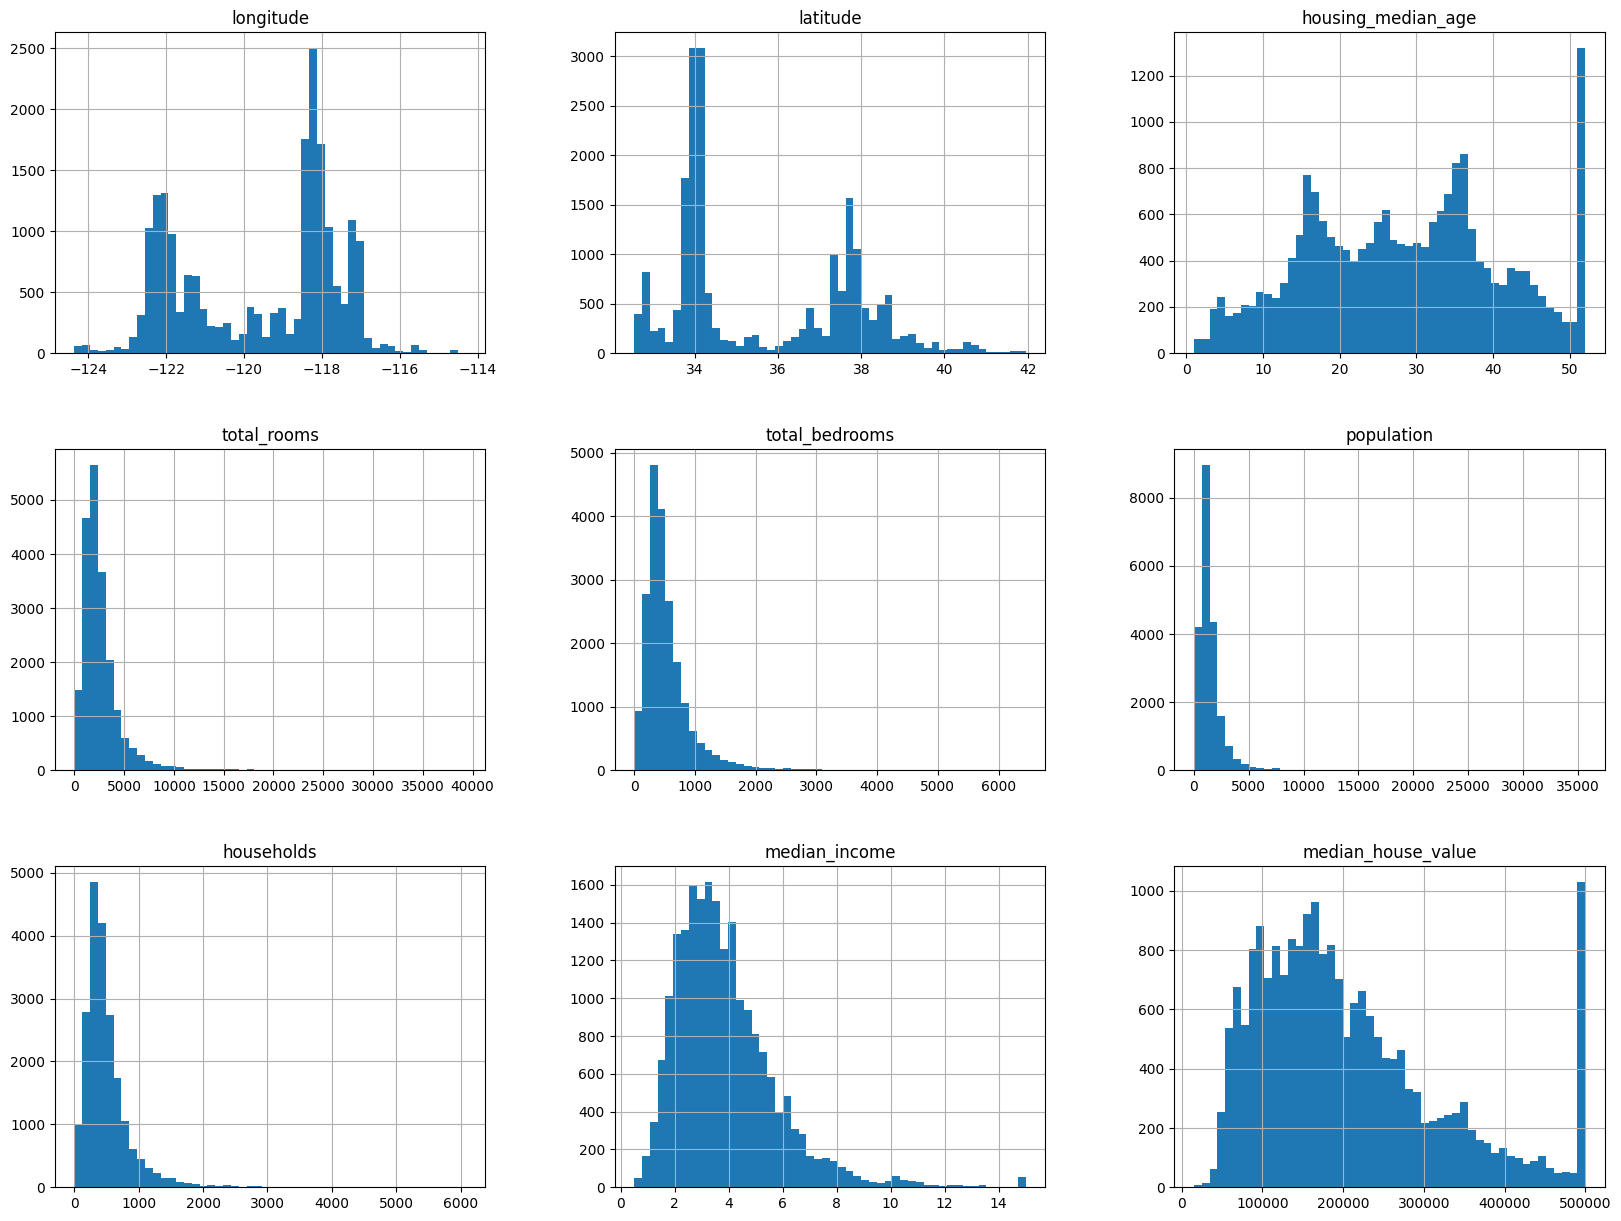

In [11]:
housing.info()
housing.describe()
housing.hist(bins=50, figsize=(20,15))
plt.show()


## 2. Data Visualization

- **Correlation heatmap** of numerical features  
- **Scatter plots** between top features and target  
- **Distribution plot** of target variable  
- **Pairplot** for selected features  


In [ ]:
# Changing 'ocean_proximity' column becaouse it didn't let me make vizualization
housing_vizual = housing.copy()
mapping = {'<1H OCEAN': 1, 'INLAND' : 2, 'NEAR OCEAN' : 3,'NEAR BAY': 4, 'ISLAND': 5}
housing_vizual['ocean_proximity'] = housing_vizual['ocean_proximity'].map(mapping)

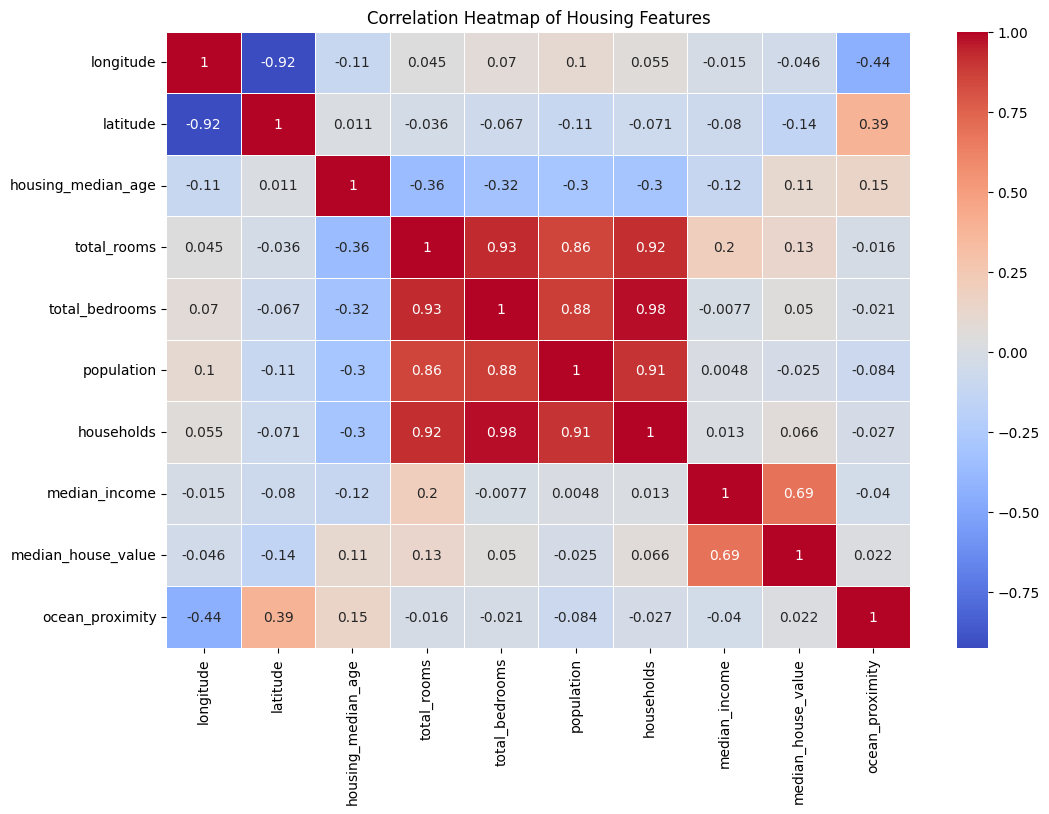

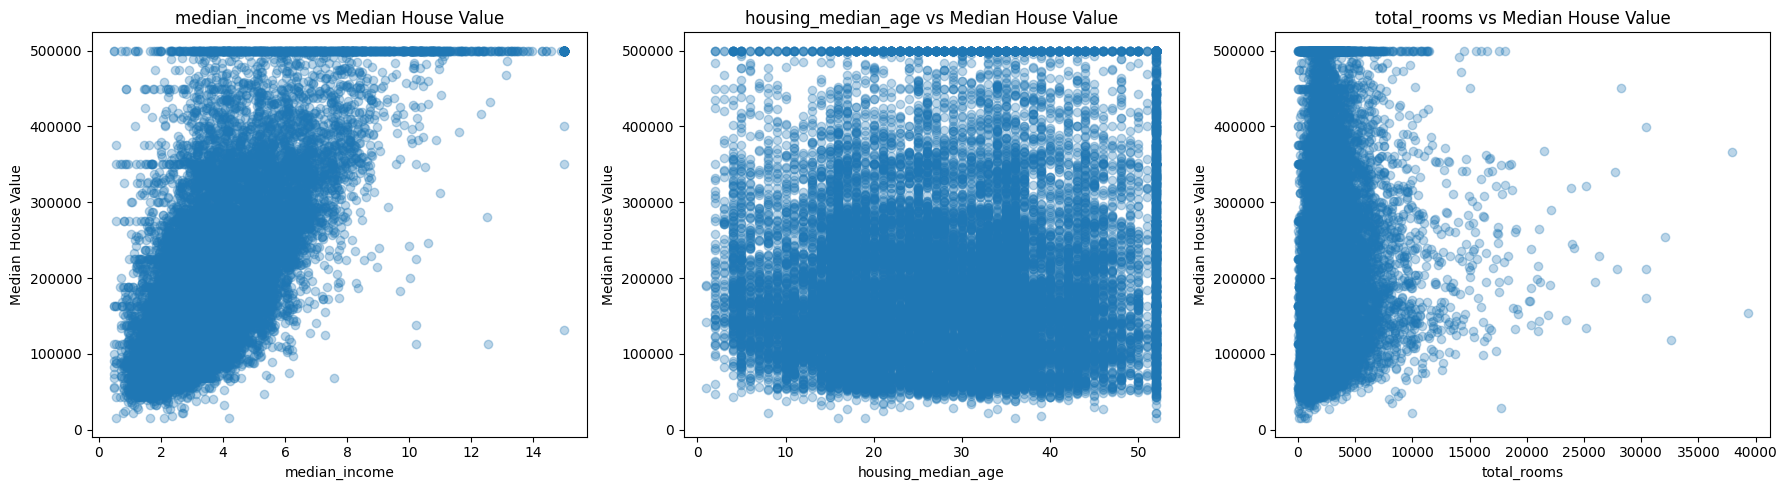

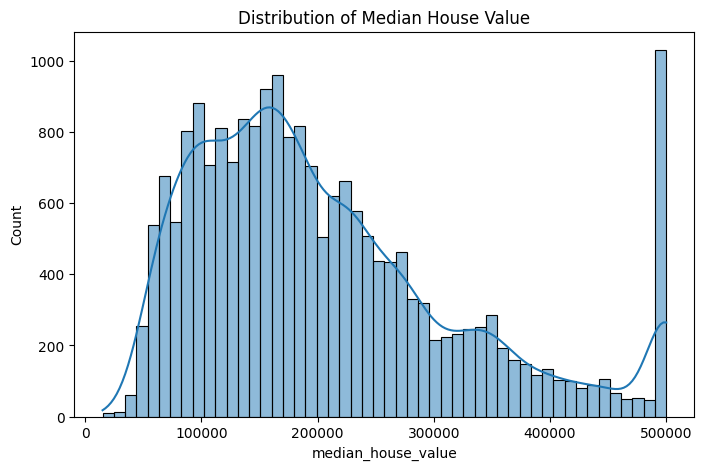

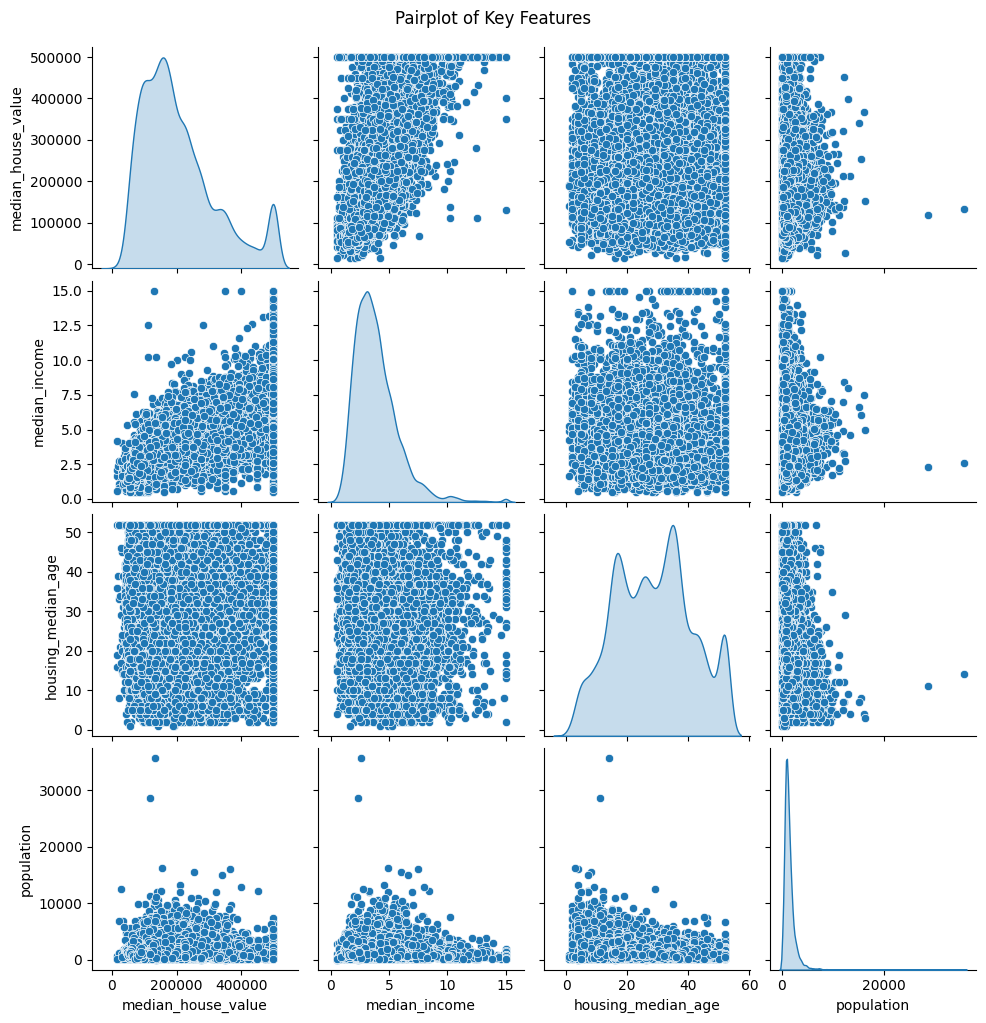

In [13]:
# Correlation heatmap
plt.figure(figsize=(12,8))
corr_matrix = housing_vizual.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Housing Features")
plt.show()

# Scatter plots of key features vs. target
key_features = ["median_income", "housing_median_age", "total_rooms"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, feature in enumerate(key_features):
    axes[i].scatter(housing_vizual[feature], housing_vizual["median_house_value"], alpha=0.3)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Median House Value")
    axes[i].set_title(f"{feature} vs Median House Value")
plt.tight_layout()
plt.show()

# Distribution of target variable
plt.figure(figsize=(8,5))
sns.histplot(housing_vizual["median_house_value"], bins=50, kde=True)
plt.title("Distribution of Median House Value")
plt.show()

# Pairplot with selected features
selected_features = ["median_house_value", "median_income", "housing_median_age", "population"]
sns.pairplot(housing_vizual[selected_features], diag_kind="kde")
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()


## 3. Data Preprocessing

- Handle missing values  
- Encode categorical variable  


In [14]:
# Impute missing values with median
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num_imputed = pd.DataFrame(imputer.fit_transform(housing_num), columns=housing_num.columns)

# Add categorical column back
housing_prepared = housing_num_imputed.copy()
housing_prepared["ocean_proximity"] = housing["ocean_proximity"]

# One-hot encode categorical
housing_prepared = pd.get_dummies(housing_prepared, drop_first=True)


## 4. Train the model

In [15]:
X = housing_prepared.drop("median_house_value", axis=1)
y = housing_prepared["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Baseline Random Forest RMSE:", rmse)
print("Baseline Random Forest R2:", r2)


Baseline Random Forest RMSE: 49038.20933848149
Baseline Random Forest R²: 0.8164888965922015


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 5. Hyperparameter Tuning with Optuna

In [17]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="r2")
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best parameters:", study.best_params)


[I 2025-08-18 23:28:49,715] A new study created in memory with name: no-name-c1016f61-4a3a-4fab-a804-fa7d32a9beb7
[I 2025-08-18 23:28:54,773] Trial 0 finished with value: 0.8122039198253294 and parameters: {'n_estimators': 203, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8122039198253294.
[I 2025-08-18 23:28:59,688] Trial 1 finished with value: 0.8052594562727253 and parameters: {'n_estimators': 216, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8122039198253294.
[I 2025-08-18 23:29:01,903] Trial 2 finished with value: 0.8067277110518685 and parameters: {'n_estimators': 78, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8122039198253294.
[I 2025-08-18 23:29:04,923] Trial 3 finished with value: 0.8118600345404822 and parameters: {'n_estimators': 85, 'max_depth': 37, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 0 with value: 

Best parameters: {'n_estimators': 281, 'max_depth': 43, 'min_samples_split': 2, 'min_samples_leaf': 2}


## Train Final Model with Best Parameters

In [18]:
best_rf = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

final_preds = best_rf.predict(X_test)

final_rmse = mean_squared_error(y_test, final_preds, squared=False)
final_r2 = r2_score(y_test, final_preds)

print("Final Random Forest RMSE:", final_rmse)
print("Final Random Forest R²:", final_r2)


Final Random Forest RMSE: 48807.232995998216
Final Random Forest R²: 0.8182135476572007


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Feature Importance

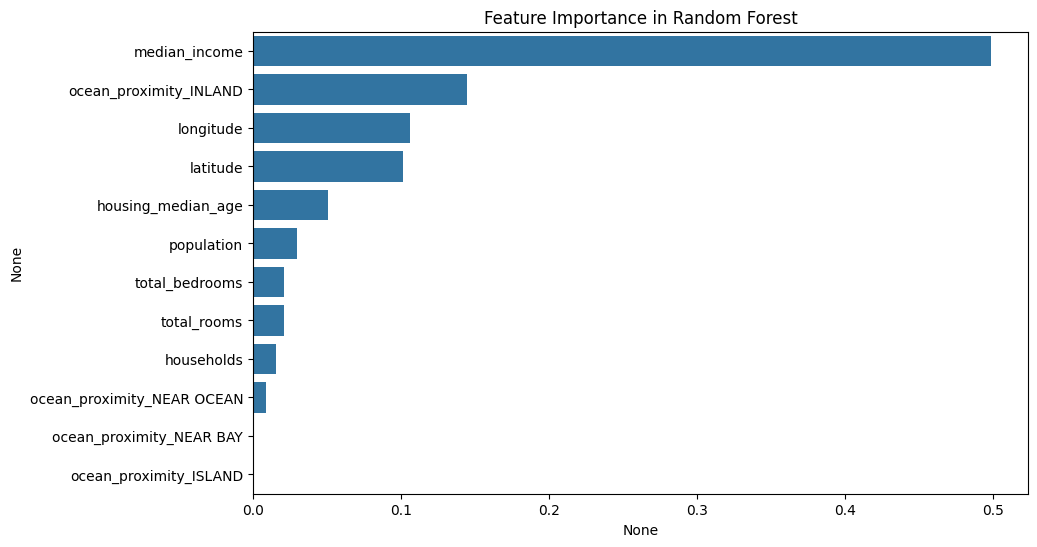

In [19]:
importances = best_rf.feature_importances_
features = X_train.columns

feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title("Feature Importance in Random Forest")
plt.show()


### Project Summary  
In this project, I built a **Machine Learning pipeline** to predict housing prices using the **California Housing Dataset**. The workflow included:  
- **Exploratory Data Analysis (EDA):** Visualized distributions, correlations, and key feature relationships with housing prices.  
- **Data Preprocessing:** Handled missing values, encoded categorical variables, and prepared the dataset for modeling.  
- **Modeling:** Trained a baseline **Random Forest Regressor**, which already showed strong predictive performance.  
- **Hyperparameter Optimization:** Used **Optuna** to fine-tune the Random Forest model, achieving improved results.  
- **Model Evaluation:** The final model achieved **RMSE = 48,807** and **R² = 0.818**, confirming Random Forest as a powerful choice for this dataset.  
- **Insights:** Feature importance analysis highlighted that **median income** and **location-related features** have the greatest impact on housing prices.  
  
